In [112]:
!pip install calmap > /dev/null 2>&1

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import calmap
import numpy as np

all_files = glob("/kaggle/input/study-exports/*.csv", recursive=True) 
df_list = [pd.read_csv(filename) for filename in all_files]

if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    raise FileNotFoundError("No CSV files found to merge.")

df["Date"] = pd.to_datetime(df["Date"])
df["Duration_hours"] = pd.to_timedelta(df["Duration"]).dt.total_seconds() / 3600
df["Weekday"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.to_period("M").astype(str)

plt.style.use('ggplot')

In [114]:
#df.columns

In [115]:
df = df.drop(columns=["Task name", "Task completed", "Project archived"])

In [116]:
# Combine Date and End time into a single string (or datetime)
#df["Date_EndTime"] = df["Date"].dt.strftime('%Y-%m-%d') + ' ' + df["End time"]

# Find all rows that share the same end timestamp
#duplicates = df[df.duplicated(subset=["Date_EndTime"], keep=False)]

# Sort for readability
#duplicates = duplicates.sort_values(by=["Date_EndTime", "Project name"])

# Display the potential duplicates
#display(duplicates)

# Optional: remove the helper column afterwards
# df.drop(columns=["Date_EndTime"], inplace=True)

In [117]:
# Combine Date and End time to a datetime
df["Recording_timestamp"] = pd.to_datetime(df["Date"].dt.strftime('%Y-%m-%d') + ' ' + df["End time"])

# Find duplicates
dupes = df[df.duplicated(subset=["Recording_timestamp"], keep=False)]

# Apply a tiny offset to duplicates to make them unique
for timestamp, group in dupes.groupby("Recording_timestamp"):
    if len(group) > 1:
        # create tiny offsets in seconds
        offsets = np.arange(len(group)) * 1  # 1 second apart
        df.loc[group.index, "Recording_timestamp"] += pd.to_timedelta(offsets, unit='s')

In [118]:
#len(df)

In [119]:
#df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df)

In [120]:
#duplicates = df[df.duplicated()]
#print(len(duplicates))

In [121]:
#duplicates

In [122]:
# Combine 'Date' and 'End time' into a single datetime column
df["Recording_timestamp"] = pd.to_datetime(df["Date"].dt.strftime('%Y-%m-%d') + ' ' + df["End time"])

# Drop duplicates based on this recording timestamp
df = df.drop_duplicates(subset=["Recording_timestamp"], keep="last").reset_index(drop=True)

# Total Study Hours per Course

This table shows the total number of hours spent on each course or project. Courses are listed in descending order, highlighting which courses have received the most study time overall.

In [123]:
# Aggregate total study hours per course
course_hours = df.groupby("Project name")["Duration_hours"].sum().reset_index()
course_hours = course_hours.rename(columns={"Duration_hours": "Total Study Hours (Hours)"})
course_hours = course_hours.sort_values(by='Total Study Hours (Hours)', ascending=False)

# Display as markdown in notebook
print("--- Total Study Hours per Project/Course ---")
print(course_hours.round(2).to_markdown(index=False, numalign="left", stralign="left"))

--- Total Study Hours per Project/Course ---
| Project name                            | Total Study Hours (Hours)   |
|:----------------------------------------|:----------------------------|
| Deep Learning for Beginners             | 8.13                        |
| Computational MRI                       | 5.46                        |
| Algorithmic Bioinformatics              | 5.29                        |
| A1.2                                    | 4.91                        |
| Generative models for signal processing | 1.98                        |
| Machine Learning for Engineers          | 1.98                        |
| Movement Neuroscience                   | 1.56                        |
| Imaging in Astronomy                    | 0.98                        |
| English                                 | 0.67                        |


# Daily Study Summary and Key Metrics

This analysis provides a complete overview of study activity across all days, including days with no recorded study time. It summarizes total study hours, calculates the daily average, and identifies the day with the highest study time, highlighting both the date and the corresponding weekday.

In [124]:
# Create complete date range
all_dates = pd.DataFrame({"Date": pd.date_range(df["Date"].min(), df["Date"].max())})

# Aggregate total study hours per day
daily_record = df.groupby("Date")["Duration_hours"].sum().reset_index()

# Merge to include all days, fill missing with 0
daily_record = all_dates.merge(daily_record, on="Date", how="left").fillna(0)
daily_record["Day of the week"] = daily_record["Date"].dt.day_name()
daily_record = daily_record.rename(columns={"Duration_hours": "Total Study Hours (Hours)"})

# Day with most study time
max_hours_row_index = daily_record["Total Study Hours (Hours)"].idxmax()
day_with_most_study = daily_record.loc[max_hours_row_index]
max_date = day_with_most_study["Date"].strftime('%Y-%m-%d')
max_weekday = day_with_most_study["Day of the week"]
max_hours = day_with_most_study["Total Study Hours (Hours)"]

# Total study hours and daily average including zero-study days
total_study_hours = df["Duration_hours"].sum()
number_of_days = len(all_dates)
daily_average_hours = total_study_hours / number_of_days

# Output metrics in notebook
print("--- Overall Study Metrics ---")
print(f"Total Sum of All Study Hours: {total_study_hours:.2f} hours")
print(f"Daily Average Study Hours (including zero days): {daily_average_hours:.2f} hours")
print("\n--- Day with Most Study Time ---")
print(f"Date: {max_date}")
print(f"Day of the week: {max_weekday}")
print(f"Total Study Hours: {max_hours:.2f} hours")

--- Overall Study Metrics ---
Total Sum of All Study Hours: 30.94 hours
Daily Average Study Hours (including zero days): 1.24 hours

--- Day with Most Study Time ---
Date: 2025-10-20
Day of the week: Monday
Total Study Hours: 5.44 hours


# Study Session Duration Analysis

This section provides insights into individual study sessions, showing the average duration of all sessions and highlighting the longest session ever recorded, along with its full details.

In [125]:
# Average session duration (in hours)
average_duration = df["Duration_hours"].mean()
print(f"Average session duration: {average_duration:.2f} hours")

# Longest session ever
longest_duration = df["Duration_hours"].max()
longest_session = df.loc[df["Duration_hours"].idxmax()]
print(f"Longest session duration: {longest_duration:.2f} hours")
print("Details of longest session:")
print(longest_session)

Average session duration: 0.70 hours
Longest session duration: 3.52 hours
Details of longest session:
Project name           Deep Learning for Beginners
Date                           2025-09-30 00:00:00
Start time                              6:30:32 pm
End time                               10:01:35 pm
Duration                                  03:31:03
Time zone                                   +02:00
Duration_hours                              3.5175
Weekday                                    Tuesday
Month                                      2025-09
Recording_timestamp            2025-09-30 22:01:35
Name: 10, dtype: object


# Study Time Distribution by Course

This pie chart visualizes the proportion of total study hours spent on each course or project, allowing a quick comparison of which courses occupy the most study time.

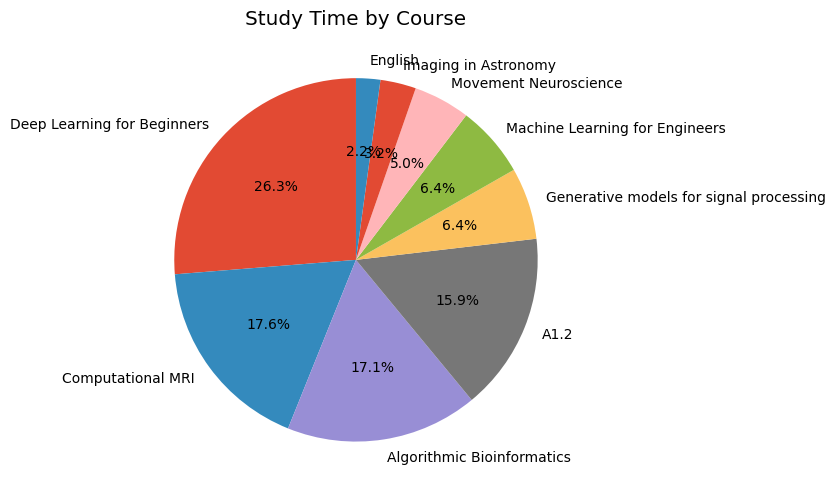

In [126]:
# Aggregate total study hours per course
course_hours = df.groupby("Project name")["Duration_hours"].sum().sort_values(ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
course_hours.plot(
    kind="pie", autopct="%1.1f%%", startangle=90, title="Study Time by Course"
)
plt.ylabel("")
plt.tight_layout()

plt.show()

# Total Study Hours per Course

This bar chart shows the total number of hours spent on each course or project. It provides a clear comparison of study time distribution across all courses.

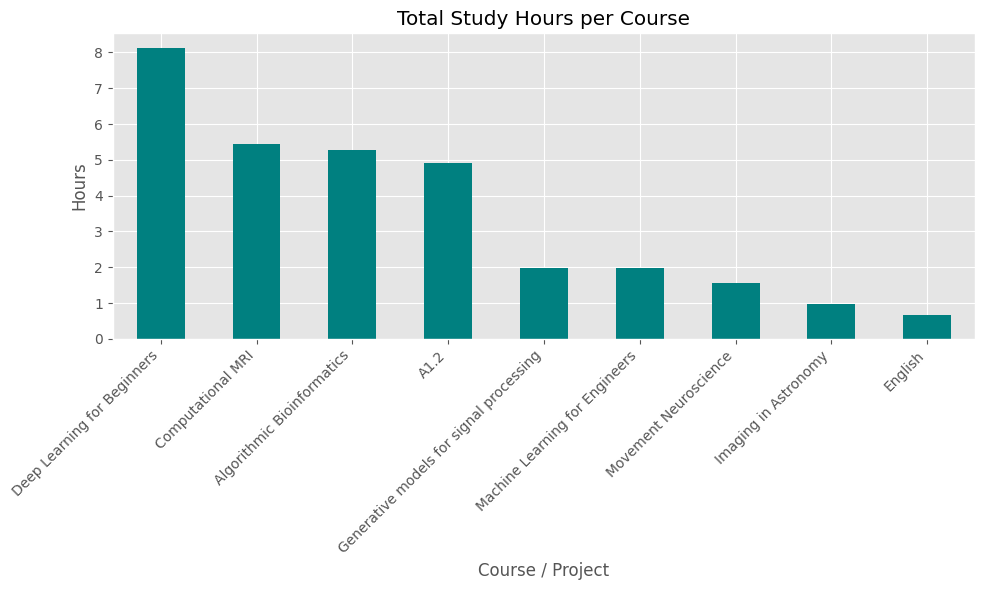

In [127]:
# Bar chart of total study hours per course
course_hours = df.groupby("Project name")["Duration_hours"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
course_hours.plot(kind="bar", title="Total Study Hours per Course", color='teal')
plt.ylabel("Hours")
plt.xlabel("Course / Project")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display in notebook
plt.show()

# Study Hours by Weekday

This bar chart displays the total study hours for each day of the week, helping to identify patterns in study habits and determine which weekdays have the highest study activity.

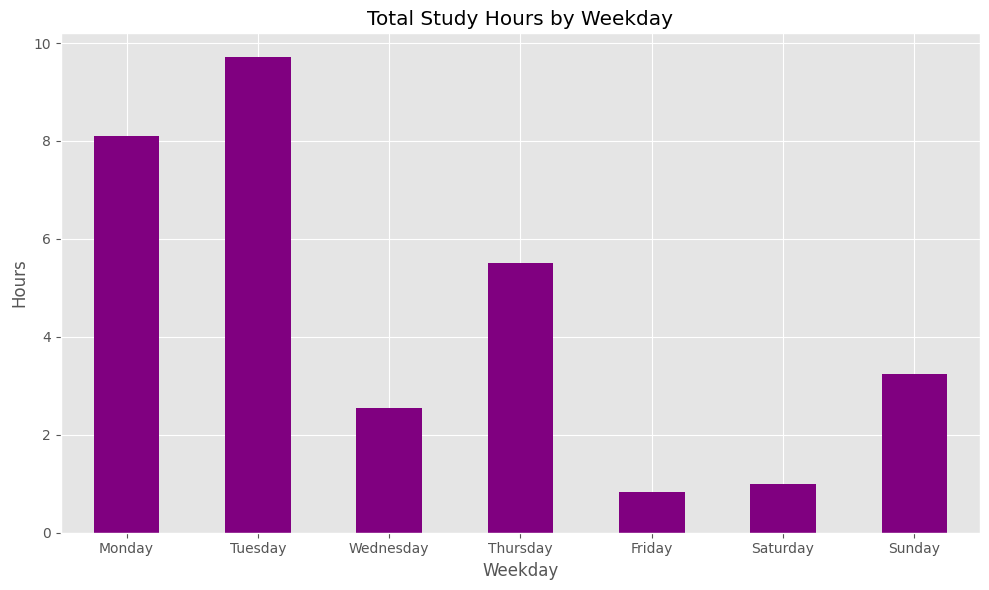

In [128]:
# Aggregate total study hours by weekday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_hours = df.groupby("Weekday")["Duration_hours"].sum().reindex(weekday_order).fillna(0)

plt.figure(figsize=(10, 6))
weekday_hours.plot(kind="bar", title="Total Study Hours by Weekday", color='purple')
plt.ylabel("Hours")
plt.xlabel("Weekday")
plt.xticks(rotation=0)
plt.tight_layout()

# Display in notebook
plt.show()

# Study Hours by Month

This bar chart illustrates the total study hours for each month, providing an overview of study trends and helping to identify periods of higher or lower study activity throughout the year.

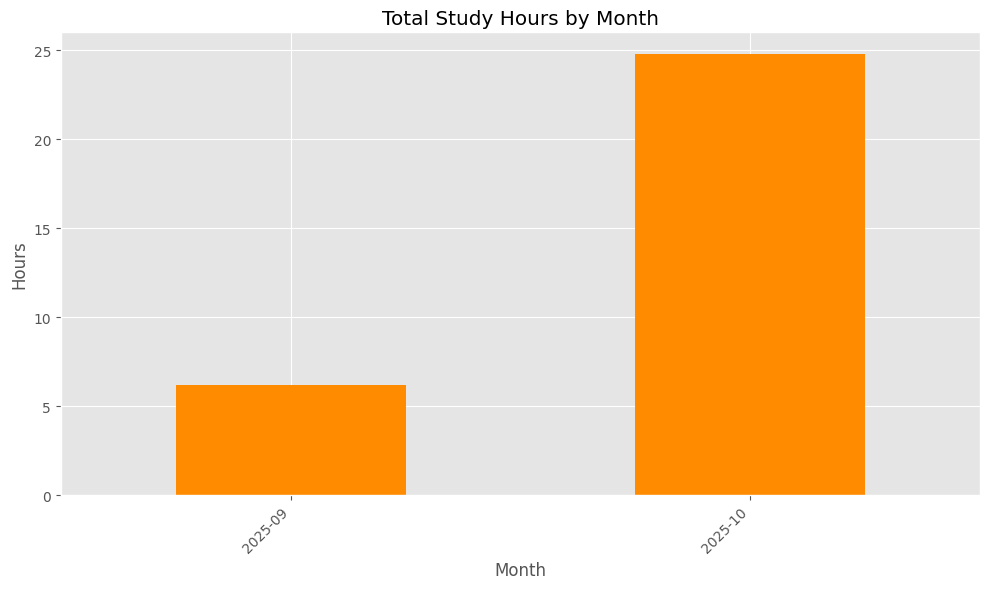

In [129]:
# Aggregate total study hours by month
monthly_hours = df.groupby("Month")["Duration_hours"].sum()

plt.figure(figsize=(10, 6))
monthly_hours.plot(kind="bar", title="Total Study Hours by Month", color='darkorange')
plt.ylabel("Hours")
plt.xlabel("Month")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# Display in notebook
plt.show()

# Monthly Study Heatmaps

These heatmaps visualize daily study hours for each month. Each cell represents a day, arranged by week and weekday, with color intensity indicating the number of study hours. This layout allows for quick identification of patterns, streaks, and gaps in daily study activity across months.

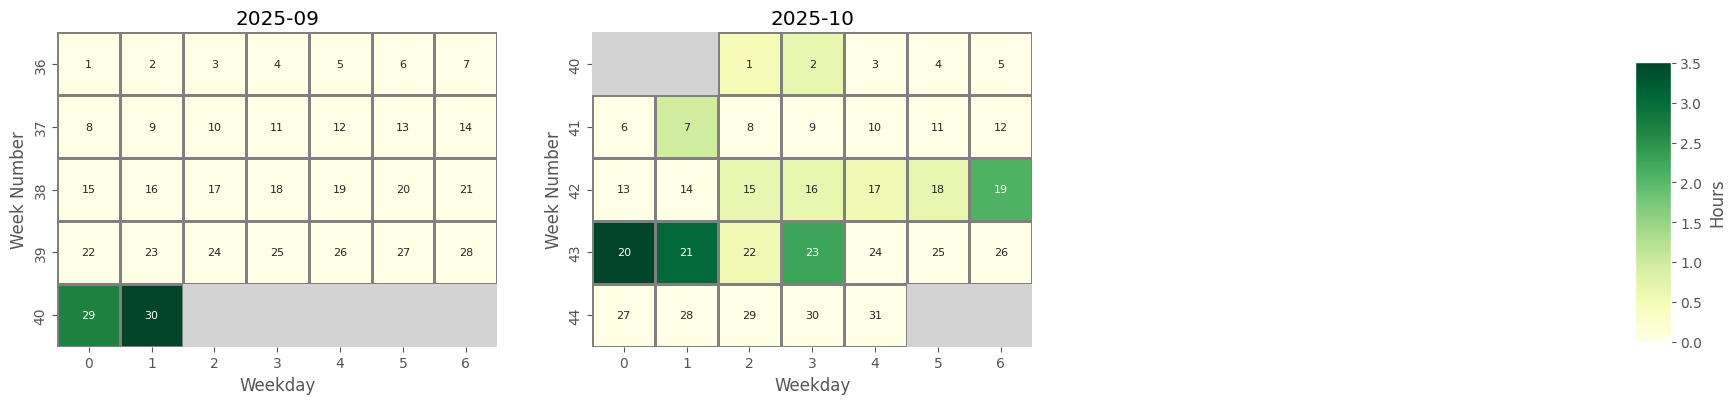

In [130]:
months = sorted(df["Date"].dt.to_period("M").astype(str).unique())
num_months = len(months)
cols = 3
rows = math.ceil(num_months / cols)

report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)

for r in range(rows):
    fig, axes = plt.subplots(1, cols, figsize=(18, 4))
    axes = axes.flatten()
    
    for c in range(cols):
        i = r * cols + c
        if i >= num_months:
            fig.delaxes(axes[c])
            continue
        
        month = months[i]
        month_data = df.groupby("Date")["Duration_hours"].sum().reset_index()
        month_data = month_data[month_data["Date"].dt.to_period("M").astype(str) == month]

        month_start = month_data["Date"].min().replace(day=1)
        month_end = month_data["Date"].max().replace(day=1) + pd.offsets.MonthEnd(1)
        all_days = pd.DataFrame({"Date": pd.date_range(month_start, month_end)})

        month_data = all_days.merge(month_data, on="Date", how="left").fillna(0)
        month_data["Week"] = month_data["Date"].dt.isocalendar().week
        month_data["Weekday"] = month_data["Date"].dt.weekday
        month_data["Day"] = month_data["Date"].dt.day

        heatmap_data = month_data.pivot(index="Week", columns="Weekday", values="Duration_hours").fillna(0)
        day_labels = month_data.pivot(index="Week", columns="Weekday", values="Day").fillna(0)
        mask = day_labels == 0

        sns.heatmap(
            heatmap_data, cmap="YlGn", linewidths=1, linecolor="gray",
            cbar=False, ax=axes[c], annot=day_labels.astype(int), fmt="d", annot_kws={"fontsize":8},
            mask=mask, square=True
        )

        for y in range(mask.shape[0]):
            for x in range(mask.shape[1]):
                if mask.iloc[y, x]:
                    axes[c].add_patch(plt.Rectangle((x, y), 1, 1, color='lightgray', lw=0))

        axes[c].set_title(f"{month}")
        axes[c].set_xlabel("Weekday")
        axes[c].set_ylabel("Week Number")

    # Single colorbar per row
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.cm.ScalarMappable(cmap="YlGn", norm=plt.Normalize(vmin=0, vmax=df["Duration_hours"].max()))
    fig.colorbar(norm, cax=cbar_ax, label="Hours")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Display in notebook
    plt.show()

# Daily Study Hours with 7-Day Rolling Average

This line chart shows the total study hours for each day, including days with no recorded study time, alongside a 7-day rolling average. The rolling average highlights trends and smoother patterns in daily study activity over time.

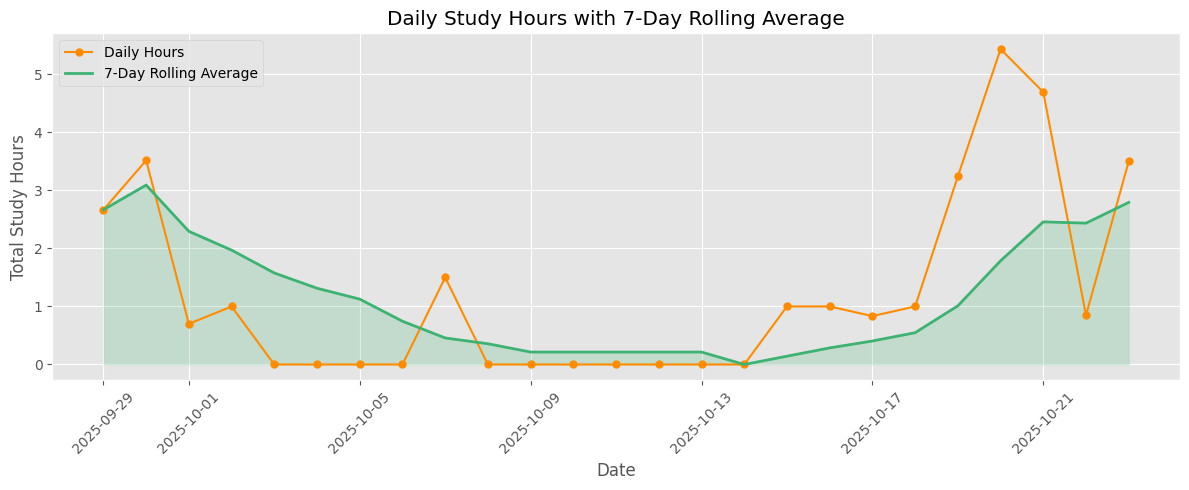

In [131]:
# Aggregate total study hours per day (including zeros)
all_dates = pd.DataFrame({"Date": pd.date_range(df["Date"].min(), df["Date"].max())})
daily_hours = df.groupby("Date")["Duration_hours"].sum().reset_index()
daily_hours = all_dates.merge(daily_hours, on="Date", how="left").fillna(0)

# Calculate 7-day rolling average
daily_hours["Rolling_Avg"] = daily_hours["Duration_hours"].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(
    daily_hours["Date"], daily_hours["Duration_hours"],
    marker="o", linestyle="-", color="darkorange", linewidth=1.5, markersize=5,
    label="Daily Hours"
)
plt.plot(
    daily_hours["Date"], daily_hours["Rolling_Avg"],
    linestyle="-", color="mediumseagreen", linewidth=2, label="7-Day Rolling Average"
)
plt.fill_between(daily_hours["Date"], daily_hours["Rolling_Avg"], color="mediumseagreen", alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Total Study Hours")
plt.title("Daily Study Hours with 7-Day Rolling Average")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Display in notebook
plt.show()

# Study Streaks Analysis

This visualization tracks consecutive days of study, showing the length of study streaks over time. Each bar represents the number of consecutive days studied, helping to identify patterns of consistency. The analysis also highlights the longest streak, including its start and end dates.

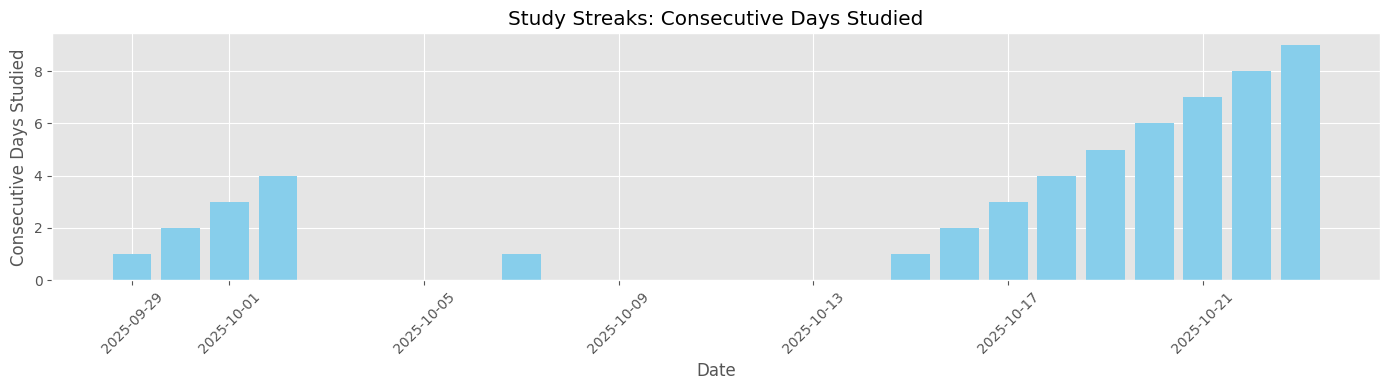

Longest streak: 9 days, from 2025-10-15 to 2025-10-23


In [132]:
# Ensure daily_hours exists (includes all dates, zero-study days)
all_dates = pd.DataFrame({"Date": pd.date_range(df["Date"].min(), df["Date"].max())})
daily_hours = df.groupby("Date")["Duration_hours"].sum().reset_index()
daily_hours = all_dates.merge(daily_hours, on="Date", how="left").fillna(0)

# Create a column indicating whether a day was studied
daily_hours["Studied"] = daily_hours["Duration_hours"] > 0

# Compute streaks: consecutive days studied
streaks = []
current_streak = 0
streak_start = None
streaks_info = []  # To track start/end of streaks

for i, studied in enumerate(daily_hours["Studied"]):
    if studied:
        if current_streak == 0:
            streak_start = daily_hours["Date"].iloc[i]
        current_streak += 1
    else:
        if current_streak > 0:
            streaks_info.append((streak_start, daily_hours["Date"].iloc[i-1], current_streak))
        current_streak = 0
        streak_start = None
    streaks.append(current_streak)

# Handle streak if notebook ends on a study day
if current_streak > 0:
    streaks_info.append((streak_start, daily_hours["Date"].iloc[-1], current_streak))

daily_hours["Streak"] = streaks

# Plot streaks
plt.figure(figsize=(14, 4))
plt.bar(daily_hours["Date"], daily_hours["Streak"], color="skyblue")
plt.title("Study Streaks: Consecutive Days Studied")
plt.xlabel("Date")
plt.ylabel("Consecutive Days Studied")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find the longest streak
if streaks_info:
    longest = max(streaks_info, key=lambda x: x[2])
    start_date, end_date, length = longest
    print(f"Longest streak: {length} days, from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
else:
    print("No study streaks found.")

# Weekly Study Pattern (Polar Plot)

This polar chart visualizes total study hours for each weekday in a circular layout. It highlights patterns in study behavior across the week, making it easy to see which days have higher or lower study activity at a glance.

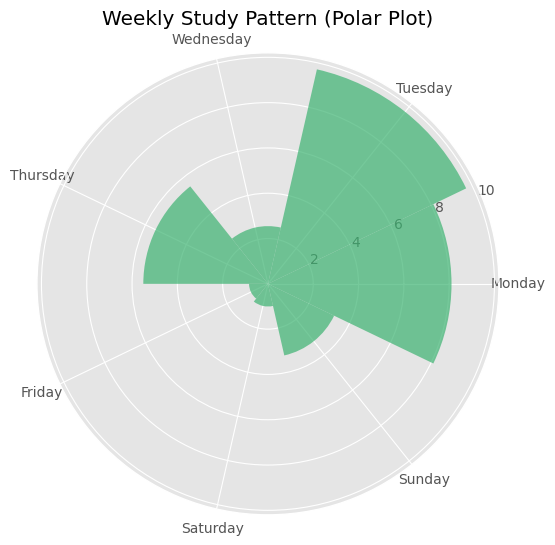

In [133]:
weekday_hours = df.groupby("Weekday")["Duration_hours"].sum().reindex(weekday_order)
theta = np.linspace(0, 2*np.pi, len(weekday_hours), endpoint=False)
radii = weekday_hours.values
width = 2*np.pi/len(weekday_hours)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=0.0, color="mediumseagreen", alpha=0.7)
ax.set_xticks(theta)
ax.set_xticklabels(weekday_order)
plt.title("Weekly Study Pattern (Polar Plot)")
plt.show()

# Study Session Duration Distribution

This density plot shows the distribution of study session durations. Peaks indicate the most common session lengths, providing insight into typical study patterns and variability in session times.

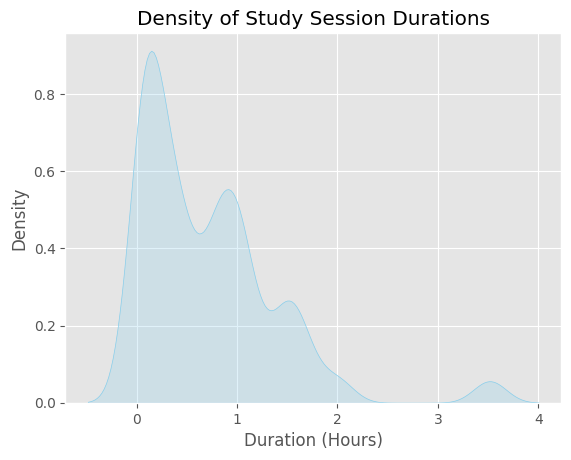

In [134]:
sns.kdeplot(df["Duration_hours"], fill=True, color="skyblue", bw_adjust=0.5)
plt.title("Density of Study Session Durations")
plt.xlabel("Duration (Hours)")
plt.ylabel("Density")
plt.show()

# Monthly Study Pattern (Polar Bar)

This polar bar chart visualizes total study hours for each month in a circular format. It provides an intuitive view of study trends throughout the year, highlighting months with higher or lower study activity.

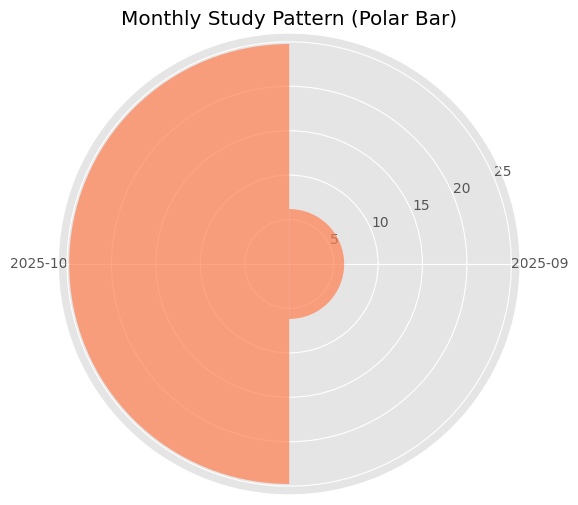

In [135]:
monthly_hours = df.groupby("Month")["Duration_hours"].sum()
theta = np.linspace(0, 2*np.pi, len(monthly_hours), endpoint=False)
radii = monthly_hours.values
width = 2*np.pi/len(monthly_hours)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.bar(theta, radii, width=width, bottom=0.0, color="coral", alpha=0.7)
ax.set_xticks(theta)
ax.set_xticklabels(monthly_hours.index)
plt.title("Monthly Study Pattern (Polar Bar)")
plt.show()

# Daily Study Hours per Course

This stacked area chart shows daily study hours broken down by course. It highlights how study time for different courses varies over time and allows for comparison of contributions from each course on a daily basis.

In [ ]:
daily_course = df.groupby(["Date","Project name"])["Duration_hours"].sum().unstack(fill_value=0)
daily_course.plot.area(figsize=(12,5), alpha=0.7)
plt.title("Daily Study Hours per Course")
plt.ylabel("Hours")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print(course_hours)
print(type(course_hours))
# pandas series and dictionaries are different.

In [ ]:
courses = [
    {"name": "Computational MRI", "ECTS": 5},
    {"name": "A1.2", "ECTS": 5},
    {"name": "Algorithmic Bioinformatics", "ECTS": 5},
    {"name": "Deep Learning for Beginners", "ECTS": 2.5},
    {"name": "English", "ECTS": 5.5},
    {"name": "Generative models for signal processing", "ECTS": 2.5},
    {"name": "Imaging in Astronomy", "ECTS": 6},
    {"name": "Machine Learning for Engineers", "ECTS": 7.5},
    {"name": "Computational MRI", "ECTS": 5},
    {"name": "Movement Neuroscience", "ECTS": 2.5},
    {"name": "Pattern recognition", "ECTS": 5},
]

total_ects = 0

for i in range(len(courses)):
    total_ects = total_ects + courses[i]["ECTS"]

print(f"Total ECTS: {total_ects}")

total_ects_hours = total_ects * 30

print(f"Total hours: {total_ects_hours}")

In [ ]:
def show_progress_bar(progress, title):
    fig, ax = plt.subplots(figsize=(5, 1))
    ax.barh(0, progress, color='dodgerblue')
    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(progress/2, 0, f"{progress}%", ha='center', va='center', color='black', fontsize=14)
    ax.set_title(title)
    
    plt.show()

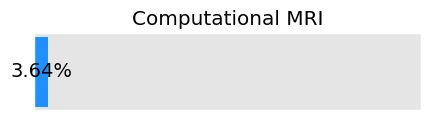

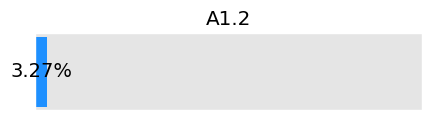

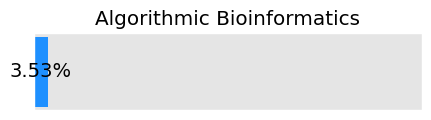

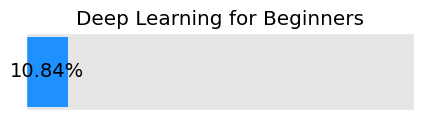

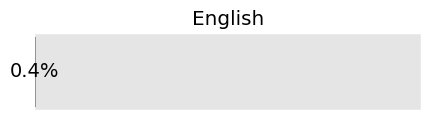

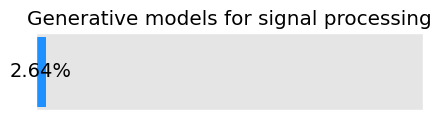

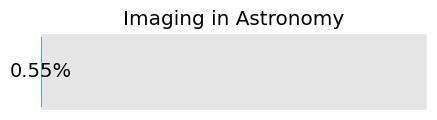

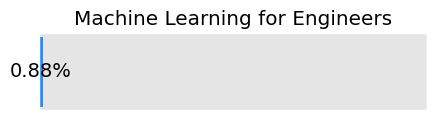

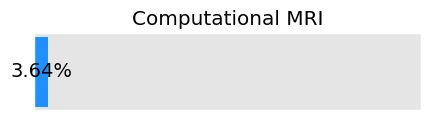

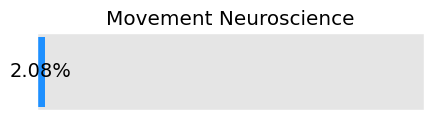

In [140]:
for i in range(len(courses)):
    course_name = courses[i]["name"]
    if course_name in course_hours:
        hours_so_far = course_hours[course_name]
        progress = (hours_so_far / (courses[i]["ECTS"] * 30)) * 100
        show_progress_bar(round(progress, 2), course_name)
    else:
        break